### OPTIMIZED LINEAR COST AVERAGING STRATEGY

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from kiteconnect import KiteConnect

In [2]:
########################### GTT ORDERS CONSTANTS ####################
EXCHANGE = KiteConnect.EXCHANGE_NSE
TRANSACTION_TYPE = KiteConnect.TRANSACTION_TYPE_BUY
PRODUCT = KiteConnect.PRODUCT_CNC
ORDER_TYPE = KiteConnect.ORDER_TYPE_LIMIT
VALIDITY = KiteConnect.VALIDITY_DAY
GTT_ACTION = "create"
NOTES = "LongTerm: Created by Python Program"
BULK_GTT_ORDERS_CSV_FILE_PATH = "../order-management/reports/bulk-gtt-orders.csv"

# NIFTY INDICES MARKET CAPs in LAKH CRORES
NIFTY_TOTAL_MARKET_CAP = 440.40
NIFTY_50_MARKET_CAP = 206.20
NIFTY_200_ALPHA_30_MARKET_CAP = 80.72
NIFTY_ALPHA_50_MARKET_CAP = 70.39
NIFTY_SMLCAP_250_MARKET_CAP = 46.55

In [ ]:
########################### SYMBOLS CONSTANTS ######################
TRADING_SYMBOL = "NIFTYBEES"

########################  POSITION SIZE USER INPUTS #######################
TOTAL_INVESTMENT_BUDGET = 700000  # 7 Lakhs total budget (includes old holdings)
BUDGET_FOR_SYMBOL = 0  #
CURRENTLY_HOLDING_QUANTITY = 0  # set > 0 to enable blended optimization
CURRENT_AVG_COST = 0

INITIAL_PRICE = 286.14
FINAL_PRICE = 266.40
TARGET_SELL_PRICE = 294.97

match TRADING_SYMBOL:
    case "NIFTYBEES":
        BUDGET_FOR_SYMBOL = (
            TOTAL_INVESTMENT_BUDGET * NIFTY_50_MARKET_CAP / NIFTY_TOTAL_MARKET_CAP
        )
    case "SMALLCAP" | "HDFCSML250":
        BUDGET_FOR_SYMBOL = (
            TOTAL_INVESTMENT_BUDGET
            * NIFTY_SMLCAP_250_MARKET_CAP
            / NIFTY_TOTAL_MARKET_CAP
        )
    case "ALPHA":
        BUDGET_FOR_SYMBOL = (
            TOTAL_INVESTMENT_BUDGET * NIFTY_ALPHA_50_MARKET_CAP / NIFTY_TOTAL_MARKET_CAP
        )
    case "ALPHAETF":
        BUDGET_FOR_SYMBOL = (
            TOTAL_INVESTMENT_BUDGET
            * NIFTY_200_ALPHA_30_MARKET_CAP
            / NIFTY_TOTAL_MARKET_CAP
        )


🔎 STEP COUNT EXPLORATION RESULTS
 Steps  Optimal p  Min Avg Cost
     6   4.927431    275.197048
     7   4.827796    275.257931
     8   4.945728    275.271135
     9   4.959353    275.285503
    10   4.974881    275.300837
    11   4.934228    275.324459
    12   4.893573    275.336028
    13   4.888211    275.345868
    14   4.827798    275.365465
    15   4.706287    275.405742
    16   4.934228    275.361342
    17   4.827796    275.373881
    18   4.959353    275.364290
    19   4.941492    275.378505
    20   4.721366    275.421312
✅ Optimal Steps: 6, p = 4.927, Min Avg Cost = ₹275.197


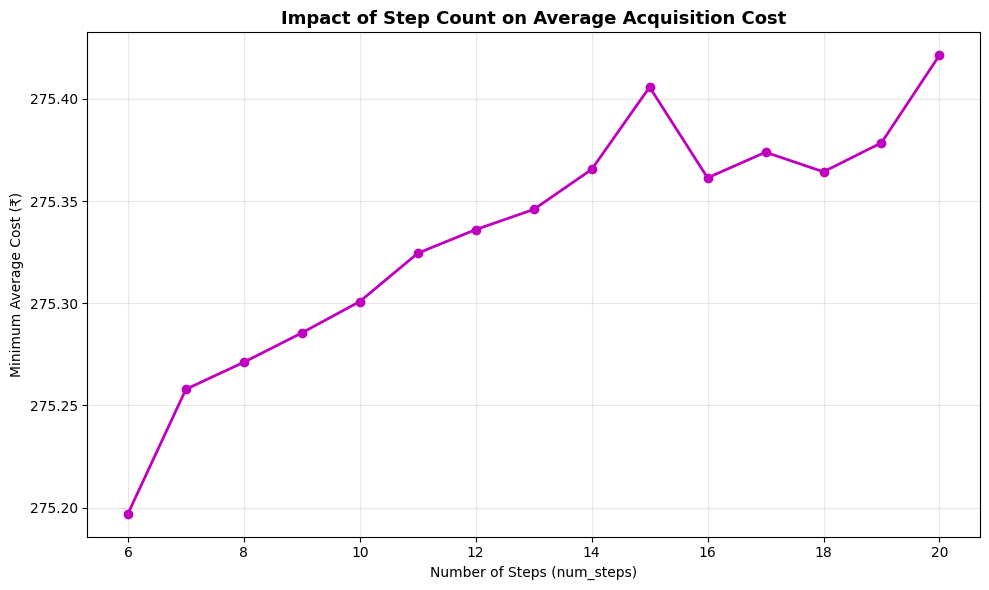


💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY
 Step  Price (₹)  Discount (%)  Quantity  Invested (₹)  Cum. Qty  Cum. Cost (₹)  Avg. Cost (₹)   P&L (₹)  P&L (%)
    1     286.14          0.00       158      45210.12       158       45210.12         286.14      0.00     0.00
    2     282.08          1.42       172      48517.47       330       93727.59         284.02   -641.75    -0.68
    3     278.07          2.82       188      52277.97       518      146005.56         281.86  -1963.08    -1.34
    4     274.13          4.20       204      55921.93       722      201927.48         279.68  -4007.72    -1.98
    5     270.24          5.56       223      60262.61       945      262190.10         277.45  -6817.14    -2.60
    6     266.40          6.90       242      64468.80      1187      326658.90         275.20 -10442.10    -3.20
Optimal weighting exponent (p): 4.927
Minimum achievable average cost (DCA only): ₹275.197
Total Quantity (combined): 1187
Total Invested (combined): ₹326,658.

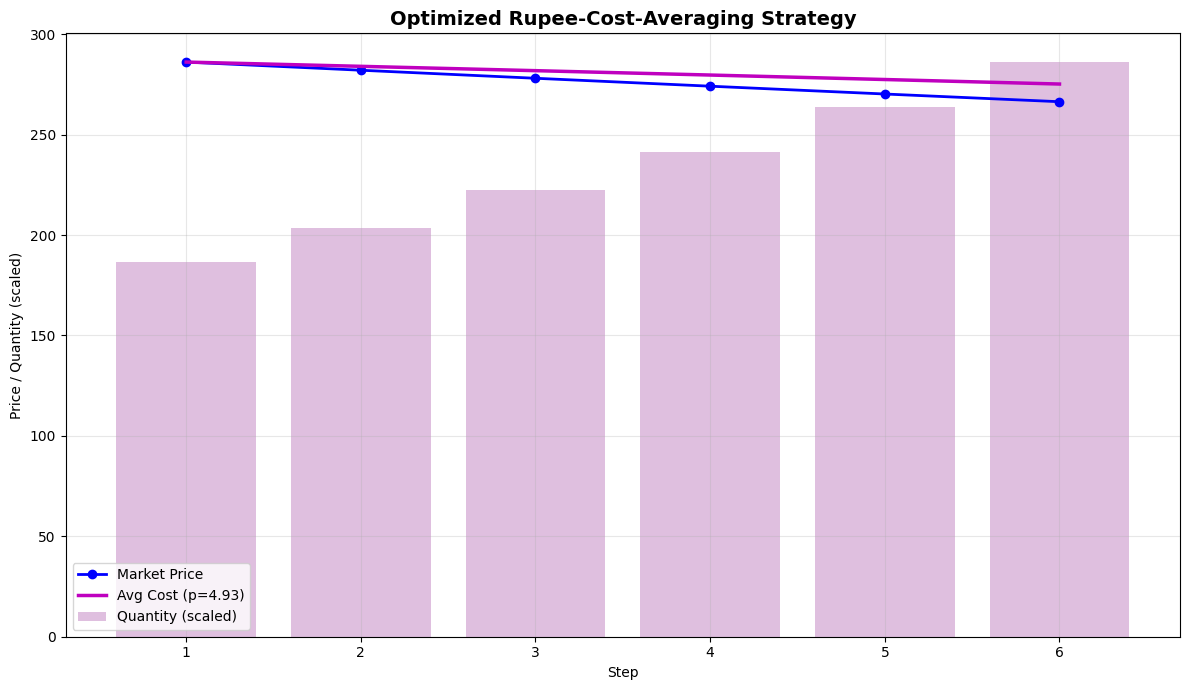

In [4]:
# =====================================================
# 1️⃣ COMPUTATION MODULE
# =====================================================
def simulate_dca(prices, total_investment, p):
    """Simulate Rupee-Cost-Averaging with weighting proportional to (1/price)^p."""
    weights = (1 / prices) ** p
    weights /= np.sum(weights)

    investments = total_investment * weights
    quantities = np.floor(investments / prices).astype(int)
    actual_investments = quantities * prices

    cumulative_qty = np.cumsum(quantities)
    cumulative_investment = np.cumsum(actual_investments)
    avg_cost = cumulative_investment / np.maximum(cumulative_qty, 1)

    df = pd.DataFrame(
        {
            "Step": np.arange(1, len(prices) + 1),
            "Price (₹)": np.round(prices, 2),
            "Discount (%)": np.round(
                ((INITIAL_PRICE - prices) / INITIAL_PRICE) * 100, 2
            ),
            # "Investment (₹)": np.round(investments, 2),
            "Quantity": quantities,
            "Invested (₹)": np.round(actual_investments, 2),
            "Cum. Qty": cumulative_qty,
            "Cum. Cost (₹)": np.round(cumulative_investment, 2),
            "Avg. Cost (₹)": np.round(avg_cost, 2),
            "P&L (₹)": np.round(prices * cumulative_qty - cumulative_investment, 2),
            "P&L (%)": np.round((prices - avg_cost) * 100 / avg_cost, 2),  # PEMDAS
        }
    )

    # TODO REFACTOR IT INTO A SEPARATE FUNCTION
    orders_count = len(prices)

    bulk_gtt_orders = {
        "action": np.full(orders_count, GTT_ACTION),
        "gtt_id": np.full(orders_count, ""),
        "tradingsymbol": np.full(orders_count, TRADING_SYMBOL),
        "exchange": np.full(orders_count, EXCHANGE),
        "transaction_type": np.full(orders_count, TRANSACTION_TYPE),
        "quantity": quantities,
        "trigger_price": np.round(prices + 0.10, 2),
        "order_price": np.round(prices, 2),
        "product": np.full(orders_count, PRODUCT),
        "order_type": np.full(orders_count, ORDER_TYPE),
        "validity": np.full(orders_count, VALIDITY),
        "last_price": np.round(prices * 1.1, 2),
        "notes": np.full(orders_count, NOTES),
    }

    pd.DataFrame(bulk_gtt_orders).to_csv(BULK_GTT_ORDERS_CSV_FILE_PATH, index=False)
    # TODO REFACTOR IT INTO A SEPARATE FUNCTION

    return df, cumulative_qty[-1], cumulative_investment[-1], avg_cost[-1]


# =====================================================
# 2️⃣ OPTIMIZATION MODULE
# =====================================================
def find_optimal_p(
    prices, total_investment, current_qty=0, current_avg_cost=0, bounds=(0, 5)
):
    """
    Find the exponent p minimizing blended average cost.
    If current holdings exist, optimization minimizes final blended cost.
    """

    def blended_avg_cost_for_p(p):
        _, new_qty, new_spent, _ = simulate_dca(prices, total_investment, p)
        total_qty = current_qty + new_qty
        total_spent = (current_qty * current_avg_cost) + new_spent
        return (total_spent / total_qty) if total_qty > 0 else np.inf

    result = minimize_scalar(blended_avg_cost_for_p, bounds=bounds, method="bounded")
    return result.x, result.fun


# =====================================================
# 3️⃣ OPTIMIZE OVER STEP COUNTS
# =====================================================
def find_optimal_steps(
    initial_price,
    final_price,
    total_investment,
    step_candidates,
    current_qty=0,
    current_avg_cost=0,
):
    """Try multiple num_steps and return configuration yielding lowest blended average cost."""
    records = []
    for num_steps in step_candidates:
        prices = np.geomspace(initial_price, final_price, num_steps)
        opt_p, blended_cost = find_optimal_p(
            prices, total_investment, current_qty, current_avg_cost
        )
        records.append((num_steps, opt_p, blended_cost))
    df_results = pd.DataFrame(records, columns=["Steps", "Optimal p", "Min Avg Cost"])
    best_row = df_results.loc[df_results["Min Avg Cost"].idxmin()]
    return best_row, df_results


# =====================================================
# 4️⃣ PLOTTING + REPORTING
# =====================================================
def plot_and_report(
    df,
    prices,
    total_qty,
    total_spent,
    final_price,
    opt_p,
    min_avg_cost,
    target_sell_price,
    current_qty=0,
    current_avg_cost=0,
):
    """Generate visualizations and report."""
    cumulative_qty = df["Cum. Qty"].values
    avg_cost = df["Avg. Cost (₹)"].values
    steps = df["Step"].values

    # Combine old + new holdings if present
    if current_qty > 0:
        old_value = current_qty * current_avg_cost
        new_qty, new_spent = (
            df["Cum. Qty"].iloc[-1],
            df["Invested (₹)"].sum(),
        )
        total_qty = current_qty + new_qty
        total_spent = old_value + new_spent
        blended_avg_cost = total_spent / total_qty
    else:
        blended_avg_cost = min_avg_cost

    # === Reporting ===
    print("\n💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY")
    print("=" * 114)
    print(df.to_string(index=False))
    print("=" * 114)

    if current_qty > 0:
        print(f"Existing Holdings: {current_qty} @ ₹{current_avg_cost:.2f}")
        print(
            f"Blended Average Cost: ₹{blended_avg_cost:.3f} "
            f"({((current_avg_cost - blended_avg_cost)/current_avg_cost)*100:+.2f}% improvement)"
        )
    print(f"Optimal weighting exponent (p): {opt_p:.3f}")
    print(f"Minimum achievable average cost (DCA only): ₹{min_avg_cost:.3f}")
    print(f"Total Quantity (combined): {total_qty}")
    print(f"Total Invested (combined): ₹{total_spent:,.2f}")

    final_value = total_qty * final_price
    profit_loss = final_value - total_spent
    profit_loss_pct = (profit_loss / total_spent) * 100
    print(f"Final Price: ₹{final_price:.2f}")
    print(f"Final Portfolio Value: ₹{final_value:,.2f}")
    print(f"P&L at Final Price: ₹{profit_loss:,.2f} ({profit_loss_pct:+.2f}%)")
    print("=" * 60)

    # === Target Simulation ===
    target_portfolio_value = total_qty * target_sell_price
    target_profit_loss = target_portfolio_value - total_spent
    target_profit_loss_pct = (target_profit_loss / total_spent) * 100
    print("\n🎯 TARGET SELL SIMULATION")
    print("=" * 60)
    print(f"Target Sell Price: ₹{target_sell_price:.2f}")
    print(f"Portfolio Value at Target: ₹{target_portfolio_value:,.2f}")
    print(
        f"Expected Profit/Loss: ₹{target_profit_loss:,.2f} ({target_profit_loss_pct:+.2f}%)"
    )
    print("=" * 60)

    # === Plot ===
    plt.figure(figsize=(12, 7))
    plt.plot(steps, prices, "bo-", linewidth=2, label="Market Price")
    plt.plot(steps, avg_cost, "m-", linewidth=2.5, label=f"Avg Cost (p={opt_p:.2f})")
    plt.bar(
        steps,
        df["Quantity"] * (max(prices) / max(df["Quantity"])),
        color="purple",
        alpha=0.25,
        label="Quantity (scaled)",
    )
    plt.title("Optimized Rupee-Cost-Averaging Strategy", fontsize=14, weight="bold")
    plt.xlabel("Step")
    plt.ylabel("Price / Quantity (scaled)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =====================================================
# 5️⃣ MAIN FUNCTION
# =====================================================
def main():
    # The number of steps/installments under which you wish to buy
    minimum_steps = 6
    maximum_steps = 20

    step_candidates = range(minimum_steps, maximum_steps + 1, 1)

    # Compute remaining investable amount if holdings exist
    invested_value = CURRENTLY_HOLDING_QUANTITY * CURRENT_AVG_COST
    remaining_investment = max(BUDGET_FOR_SYMBOL - invested_value, 0)

    # === Optimization over step counts ===
    best_cfg, df_summary = find_optimal_steps(
        INITIAL_PRICE,
        FINAL_PRICE,
        remaining_investment,
        step_candidates,
        CURRENTLY_HOLDING_QUANTITY,
        CURRENT_AVG_COST,
    )

    # === Show tabular summary ===
    print("\n🔎 STEP COUNT EXPLORATION RESULTS")
    print("=" * 33)
    print(df_summary.to_string(index=False))
    print("=" * 32)
    print(
        f"✅ Optimal Steps: {int(best_cfg['Steps'])}, p = {best_cfg['Optimal p']:.3f}, "
        f"Min Avg Cost = ₹{best_cfg['Min Avg Cost']:.3f}"
    )

    # === Chart: Avg Cost vs. Steps ===
    plt.figure(figsize=(10, 6))
    plt.plot(df_summary["Steps"], df_summary["Min Avg Cost"], "o-m", linewidth=2)
    plt.title(
        "Impact of Step Count on Average Acquisition Cost", fontsize=13, weight="bold"
    )
    plt.xlabel("Number of Steps (num_steps)")
    plt.ylabel("Minimum Average Cost (₹)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # === Final Simulation with best configuration ===
    prices = np.geomspace(INITIAL_PRICE, FINAL_PRICE, int(best_cfg["Steps"]))
    opt_p = best_cfg["Optimal p"]
    df, total_qty_new, total_spent_new, min_avg_cost = simulate_dca(
        prices, remaining_investment, opt_p
    )

    # === Reporting & Plotting ===
    plot_and_report(
        df,
        prices,
        total_qty_new,
        total_spent_new,
        FINAL_PRICE,
        opt_p,
        min_avg_cost,
        TARGET_SELL_PRICE,
        CURRENTLY_HOLDING_QUANTITY,
        CURRENT_AVG_COST,
    )


# =====================================================
# ENTRY POINT
# =====================================================
if __name__ == "__main__":
    main()